In [1]:
import pandas as pd
import numpy as np

In [2]:
from typing import NamedTuple, Any, List

## Четыре стадии:
1. Сформировать поток
2. Получаем элемент
3. Делаем предсказание
4. Получаем метку
5. Считаем лосс
6. Делаем градиентный шаг

## Подготавливаем данные

In [3]:
from scipy.special import expit
import datetime

In [4]:
contacts = pd.read_csv('../risk_propagation/contacts_15meters_30sec_distancies_updated.csv')

In [5]:
num_of_contacts = contacts.groupby(['user1', 'day', 'user2']).first().groupby(['user1', 'day']).count()['time']

In [6]:
contacts_distance = contacts.groupby(['user1', 'day', 'user2']).mean()['distance']
contacts_duration = contacts.groupby(['user1', 'day', 'user2']).count()['time']

In [7]:
contacts_w_nums = contacts.merge(num_of_contacts, on=['day', 'user1'], how='inner')

In [9]:
contacts_w_nums = contacts.merge(num_of_contacts, on=['day', 'user1'], how='inner')
contacts_w_distancies = contacts_w_nums.merge(contacts_distance, on=['day', 'user1', 'user2'], how='inner')
contacts_w_durations = contacts_w_distancies.merge(contacts_duration, on=['day', 'user1', 'user2'], how='inner')

In [11]:
contacts_w_features = contacts_w_durations.rename(columns={'time_x': 'time', 'time_y': 'num_contacts', 'time': 'duration',
                                                  'distance_y':'mean_distance'})
contacts_w_features = contacts_w_features.groupby(['user1', 'day', 'user2']).first()

In [12]:
contacts_w_features['target'] = 0 

In [13]:
targets = pd.read_csv('../coronavirus_data/infusr.csv')

In [15]:
contacts_w_features = contacts_w_features.reset_index(level='user2')

In [18]:
contacts_w_features = contacts_w_features.sort_values('time')

## Сравниваем модели

In [19]:
from library import GraphElem, Graph, Pipeline, Elem
from contacts_features import CurrentGraph as FeaturesGraph, Model as FeaturesModel

In [23]:
import datetime
from sklearn.metrics import roc_auc_score

In [24]:
def Train(alpha, h):
    graph = FeaturesGraph()
    model = FeaturesModel(alpha, h)
    pipeline = Pipeline(graph, model, print_every = 50)
    for index, row in contacts_w_features.iterrows():
        dttm = datetime.datetime.strptime(index[1], '%Y-%m-%d')
        user1 = index[0]
        shifted_time = (dttm  + datetime.timedelta(days=-1)).strftime('%Y-%m-%d')  
        features = []
        if (user1, shifted_time) in contacts_w_features.index:
            shift = contacts_w_features.loc[(user1, shifted_time)]
            for other_index, other_row in shift.iterrows():
                features.append([other_row['duration'], other_row['mean_distance']])
        elem = Elem(row['target'], features, index[1], index[0])
        pipeline([elem])
    return model, graph

In [25]:
def calc_metrics(graph):
    thresholds = np.arange(0, 1, 0.01)
    predictions = []
    targets = []
    for date, value in graph.storage.items():
        for user, elem in value.items():
            if elem.elem.target is not None and elem.prediction == elem.prediction:
                predictions.append(elem.prediction)
                targets.append(elem.elem.target)
    predictions = np.array(predictions)
    targets = np.array(targets)
    precisions = []
    recalls = []
    for threshold in thresholds:
        verdict = predictions > threshold
        tp = ((verdict == True) & (targets == 1)).sum()
        fp = ((verdict == True) & (targets == 0)).sum()
        tn = ((verdict == False) & (targets == 0)).sum()
        fn = ((verdict == False) & (targets == 1)).sum()
        precision = tp*1.0/(tp + fn)
        recall = tp*1.0/(tp + fp)
        recalls.append(precision)
        precisions.append(recall)
    return recalls, precisions, targets, predictions

In [26]:
def grid_search():
    x = np.arange(0.025, 1, 0.025)
    y = np.arange(0.025, 1, 0.025)
    max_alpha = -1
    max_h = -1
    max_roc_auc = -1
    for alpha in x:
        for h in y:
            model, graph = Train(alpha, h)
            recalls, precisions, targets, predictions  = calc_metrics(graph)
            roc_auc = roc_auc_score(targets, predictions)
            if roc_auc > max_roc_auc:
                max_alpha = alpha
                max_h = h
                max_roc_auc = roc_auc
    return max_alpha, max_h

In [ ]:
max_alpha_features, max_h_features = grid_search()

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value e

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Docume

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars


/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28:

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encounte

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28:

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encounte

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encounte

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28:

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28:

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28:

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid val

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in mult

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28:

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28:

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encounte

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28:

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: in

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid val

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero enco

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid val

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in m

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28:

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28:

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_gra

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28:

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_gra

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28:

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_gra

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered i

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult


In [44]:
model, graph = Train(0.025, 0.25)
recalls_feats, precisions_feats, targets, predictions  = calc_metrics(graph)

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  # This is added back by InteractiveShellApp.init_path()
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
from contacts_counts import CurrentGraph as CountGraph, Model as CountModel

In [28]:
def CountTrain(alpha, h):
    graph = CountGraph()
    model = CountModel(alpha, h)
    pipeline = Pipeline(graph, model, print_every = 50)
    for index, row in contacts_w_features.iterrows():
        dttm = datetime.datetime.strptime(index[1], '%Y-%m-%d')
        user1 = index[0]
        contacts_num = 0
        shifted_time = (dttm  + datetime.timedelta(days=-1)).strftime('%Y-%m-%d') 
        if (user, shifted_time) in contacts_w_features.index:
            contacts_num = contacts_w_features.loc[(user, shifted_time)]['num_contacts'][0]
        elem = Elem(row['target'], [contacts_num], index[1], index[0])
        pipeline([elem])
    return model, graph


In [29]:
def grid_search():
    x = np.arange(0.025, 1, 0.025)
    y = np.arange(0.025, 1, 0.025)
    max_alpha = -1
    max_h = -1
    max_roc_auc = -1
    for alpha in x:
        for h in y:
            model, graph = CountTrain(alpha, h)
            recalls, precisions, targets, predictions  = calc_metrics(graph)
            roc_auc = roc_auc_score(targets, predictions)
            if roc_auc > max_roc_auc:
                max_alpha = alpha
                max_h = h
                max_roc_auc = roc_auc
    return max_alpha, max_h

In [30]:
max_alpha, max_h = grid_search()

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value e

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Docume

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28:

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encounte

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28:

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encounte

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28:

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28:

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid val

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28:

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28:

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encounte

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid val

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28:

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28:

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encounte

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encounte

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in m

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28:

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered i

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in m

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_sca

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encounte

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value enc

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_gra

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered i

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performa

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_gra

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_gra

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_gra

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value enc

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value enc

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered i

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_gra

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered i

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered i

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28:

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_gra

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_gra

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_gra

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_gra

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_gra

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performa

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_gra

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: Runtim

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_gra

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_gra

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered i

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_gra

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered i

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_gra

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered i

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered i

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered i

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_gra

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_gra

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value enc

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_gra

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in m

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_gra

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered i

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered i

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_gra

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_gra

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value enc

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered 

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered i

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  mult = 5.0 / prev_p
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered i

/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:43: RuntimeWarning: invalid value encountered in multiply
  new_grad = np.array([mu_grad, beta_grad, w0_grad, w1_grad])*mult
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:30: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:28: RuntimeWarning: divide by zero encountered in log
  return 5*np.log(p)
/Users/anirogozina/Documents/risk_propagation/risk_framework/contacts_counts.py:36: RuntimeWarning: divide by zero encountered in double_sca

In [46]:
model, graph = CountTrain(0.025, 0.275)
recalls, precisions, targets, predictions  = calc_metrics(graph)

/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2877: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/Users/anirogozina/Documents/risk/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


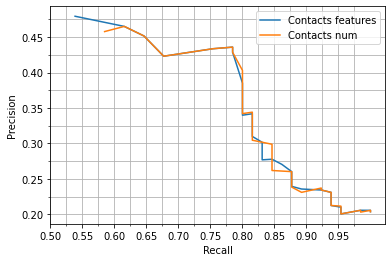

In [55]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 1, 0.2)
minor_ticks = np.arange(0, 1, 0.05)
#plt.plot(good_orders_old, non_found_orders_old, label='Old_model')
plt.plot(recalls_feats, precisions_feats, label='Contacts features')
plt.plot(recalls, precisions, label='Contacts num')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
ax.set_xticks(np.arange(0.5, 1, 0.05))
ax.set_xticks(np.arange(0.5, 1, 0.025), minor=True)
ax.set_yticks(np.arange(0.2, 0.5, 0.05))
ax.set_yticks(np.arange(0.2, 0.5, 0.025), minor=True)

# And a corresponding grid
ax.grid(which='both')


# Or if you want different settings for the grids:
plt.savefig('comparison.png')